In [1]:
import os,sys
#Change and check directory
os.chdir('C:\WGU\D209\PA\Task2')
os.getcwd()

'C:\\WGU\\D209\\PA\\Task2'

In [2]:
#import necessary libraries
import pandas as pd
#For array functionality
import numpy as np
#visualizations
import seaborn as sns
#For preprocessing the data
from sklearn.model_selection import train_test_split
#for getting the best value for k
from sklearn.model_selection import GridSearchCV
#for the Random Forrest model
import sklearn
from sklearn.ensemble import RandomForestRegressor
#for analyzing the model
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE

#load the data frame
df = pd.read_csv('churn_clean.csv', index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_id           10000 non-null  object 
 1   Interaction           10000 non-null  object 
 2   UID                   10000 non-null  object 
 3   City                  10000 non-null  object 
 4   State                 10000 non-null  object 
 5   County                10000 non-null  object 
 6   Zip                   10000 non-null  int64  
 7   Lat                   10000 non-null  float64
 8   Lng                   10000 non-null  float64
 9   Population            10000 non-null  int64  
 10  Area                  10000 non-null  object 
 11  TimeZone              10000 non-null  object 
 12  Job                   10000 non-null  object 
 13  Children              10000 non-null  int64  
 14  Age                   10000 non-null  int64  
 15  Income                10

In [3]:
#Data Cleaning
#Detect and treat NULLS - we can see from the describe call that there is only one column with missing values
#InternetService: This column actually doesn't have any null values it just got read in as NULL rather than None indicating the customer doesn't have this service
df['InternetService'].fillna('None',inplace=True)

In [4]:
#Drop initial columns we won't be using
df = df.drop(columns=['Churn','Customer_id', 'Interaction', 'UID', 'City', 'State', 'County', 'Zip', 'Lat', 'Lng', 'TimeZone', 'Area', 'Job', 'Children', 'Age', 'Income', 'Marital', 'Gender', 'Techie', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8'])

In [5]:
#Summary Statistics and Reviewing for Outliers
df.describe()

,Population,Outage_sec_perweek,Email,Contacts,Yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9756.562400,10.001848,12.016000,0.994200,0.398000,34.526188,172.624816,3392.341550
std,14432.698671,2.976019,3.025898,0.988466,0.635953,26.443063,42.943094,2185.294852
min,0.000000,0.099747,1.000000,0.000000,0.000000,1.000259,79.978860,155.506715
25%,738.000000,8.018214,10.000000,0.000000,0.000000,7.917694,139.979239,1236.470827
50%,2910.500000,10.018560,12.000000,1.000000,0.000000,35.430507,167.484700,3279.536903
75%,13168.000000,11.969485,14.000000,2.000000,1.000000,61.479795,200.734725,5586.141370
max,111850.000000,21.207230,23.000000,7.000000,6.000000,71.999280,290.160419,7158.981530


In [6]:
categorical_columns = ['Port_modem', 'Tablet', 'Phone', 'Multiple', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Contract', 'InternetService', 'PaymentMethod']
for x in categorical_columns:
    print(df[x].describe())

count     10000
unique        2
top          No
freq       5166
Name: Port_modem, dtype: object
count     10000
unique        2
top          No
freq       7009
Name: Tablet, dtype: object
count     10000
unique        2
top         Yes
freq       9067
Name: Phone, dtype: object
count     10000
unique        2
top          No
freq       5392
Name: Multiple, dtype: object
count     10000
unique        2
top          No
freq       6424
Name: OnlineSecurity, dtype: object
count     10000
unique        2
top          No
freq       5494
Name: OnlineBackup, dtype: object
count     10000
unique        2
top          No
freq       5614
Name: DeviceProtection, dtype: object
count     10000
unique        2
top          No
freq       6250
Name: TechSupport, dtype: object
count     10000
unique        2
top          No
freq       5071
Name: StreamingTV, dtype: object
count     10000
unique        2
top          No
freq       5110
Name: StreamingMovies, dtype: object
count     10000
unique        2


In [7]:
#One hot encoding 
continuous_columns = ['Population', 'Outage_sec_perweek', 'Email', 'Contacts', 'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype = int)
#Rename the columns for clarity and to remove spaces
df = df.rename(columns = {'Contract_One year':'Contract_One_Year', 'Contract_Two Year':'Contract_Two_Year','InternetService_Fiber Optic':'InternetService_Fiber_Optic', 'InternetService_Fiber Optic':'InternetService_Fiber_Optic', 'PaymentMethod_Credit Card (automatic)':'PaymentMethod_CC', 'PaymentMethod_Electronic Check':'PaymentMethod_ECheck', 'PaymentMethod_Mailed Check':'PaymentMethod_MCheck'})
categorical_columns = ['Port_modem_Yes', 'Tablet_Yes', 'Phone_Yes', 'Multiple_Yes', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'PaperlessBilling_Yes', 'Contract_One_Year', 'Contract_Two_Year', 'InternetService_Fiber_Optic','InternetService_None', 'PaymentMethod_CC', 'PaymentMethod_ECheck', 'PaymentMethod_MCheck']
#Store all the columns for easy access later
columns = categorical_columns + continuous_columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Population                   10000 non-null  int64  
 1   Outage_sec_perweek           10000 non-null  float64
 2   Email                        10000 non-null  int64  
 3   Contacts                     10000 non-null  int64  
 4   Yearly_equip_failure         10000 non-null  int64  
 5   Tenure                       10000 non-null  float64
 6   MonthlyCharge                10000 non-null  float64
 7   Bandwidth_GB_Year            10000 non-null  float64
 8   Port_modem_Yes               10000 non-null  int32  
 9   Tablet_Yes                   10000 non-null  int32  
 10  Phone_Yes                    10000 non-null  int32  
 11  Multiple_Yes                 10000 non-null  int32  
 12  OnlineSecurity_Yes           10000 non-null  int32  
 13  OnlineBackup_Yes     

<Axes: >

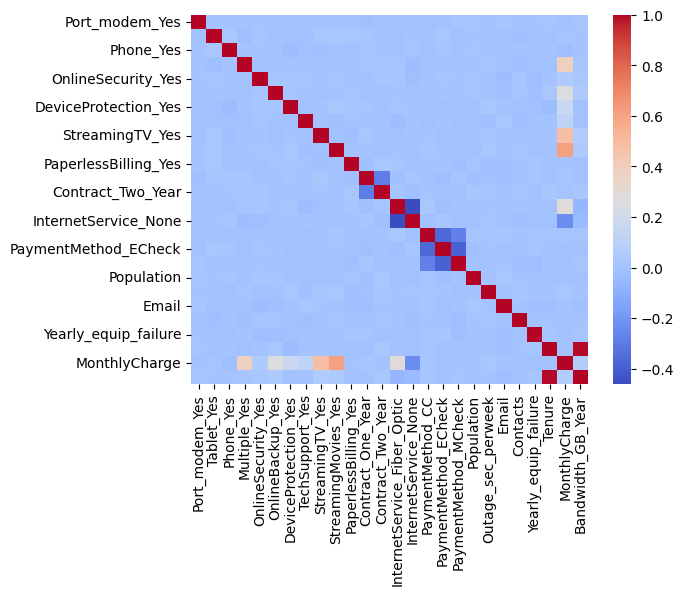

In [8]:
#Look for correlation in the data and remove highly correlated features
sns.heatmap(data = df[columns].corr(), annot=False, cmap='coolwarm')

In [9]:
#Remove the higher correlated features based on the heatmap
df = df.drop(columns = ['Multiple_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Population                   10000 non-null  int64  
 1   Outage_sec_perweek           10000 non-null  float64
 2   Email                        10000 non-null  int64  
 3   Contacts                     10000 non-null  int64  
 4   Yearly_equip_failure         10000 non-null  int64  
 5   Tenure                       10000 non-null  float64
 6   MonthlyCharge                10000 non-null  float64
 7   Bandwidth_GB_Year            10000 non-null  float64
 8   Port_modem_Yes               10000 non-null  int32  
 9   Tablet_Yes                   10000 non-null  int32  
 10  Phone_Yes                    10000 non-null  int32  
 11  OnlineSecurity_Yes           10000 non-null  int32  
 12  OnlineBackup_Yes             10000 non-null  int32  
 13  DeviceProtection_Yes 

In [11]:
#Export the prepared data set
df.to_csv('PREPARED_churn_clean_data.csv')

In [12]:
# Set up the data as X and y and split the data for training and testing 
X = df.drop('Tenure', axis=1)
y = df['Tenure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Export training and test datasets
np.savetxt('X_train.csv', X_train, delimiter=',')
np.savetxt('X_test.csv', X_test, delimiter=',')
np.savetxt('y_train.csv', y_train, delimiter=',')
np.savetxt('y_test.csv', y_test, delimiter=',')

In [13]:
#Use grid 
param_grid = {
            'n_estimators': [10, 50, 100],
            'max_depth': [8, None],
            'max_features': ['log2','sqrt']
             }
rf = RandomForestRegressor(random_state = 1)
rf_cv = GridSearchCV(rf, param_grid)
rf_cv.fit(X_train, y_train)
rf_cv.best_params_

{'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}

In [14]:
#Fit the Random Forest model using grid search results
rf = RandomForestRegressor(max_depth=None, max_features='log2', n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features='log2')

In [15]:
# Model Validation
y_pred = rf.predict(X_test)
from sklearn.metrics import accuracy_score
print('R2: ', rf.score(X_test,y_test))
print('MAE: ', MAE(y_test, y_pred))
print('MSE: ', MSE(y_test, y_pred))
print('RMSE: ', (MSE(y_test, y_pred))**(1/2))

R2:  0.9788332692596627
MAE:  3.14977810574662
MSE:  14.90293790779433
RMSE:  3.860432347262976
